In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os.path

import librosa
import pandas
import numpy

from matplotlib import pyplot as plt
import librosa.display

from sed_utils import events_from_predictions, merge_overlapped_predictions, weighted_binary_crossentropy, build_sednet, compute_pr_curve, dataset_split_sequentially, compute_windows, make_continious_labels


## Configuration

In [76]:
# input
audio_path = 'data/source2.wav'
annotations_path = 'data/annotations.csv'

# samplerate to process at
samplerate = 16000

# temporal resolution, both for spectrogram and prediction output
time_resolution = 0.10 

# how much data to use for
val_size = 0.15
test_size = 0.15


In [5]:

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_fft = next_power_of_2(hop_length)

print(hop_length, n_fft)

1600 2048


## Load labels

In [6]:
def load_annotations(path):
    df = pandas.read_csv(path, header=None)
    df.columns = ['start', 'end', 'event']
    
    # drop duplicates
    df = df[~df['start'].duplicated()]
    
    df['duration'] = df['end'] - df['start']
    df = df.sort_values('start')
    
    return df


annotations = load_annotations(annotations_path)
annotations['file'] = os.path.basename(audio_path)
annotations.head(1)

,start,end,event,duration,file
0,7.055938,7.220668,yes,0.16473,source2.wav


In [7]:
annotations.event.value_counts()

event
yes    120
Name: count, dtype: int64

### Duration of events

Impacts what time resolution and window duration we should choose. 

<Axes: >

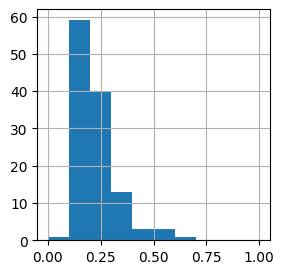

In [8]:
annotations.duration.hist(width=0.10, range=(0, 1.0), figsize=(3, 3))

### Time between events


Impacts what time resolution and window duration we should choose.

<Axes: >

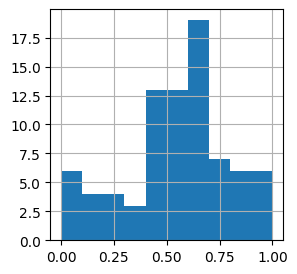

In [9]:
(annotations['start'] - (annotations['end'].shift(1))).hist(width=0.1, range=(0, 1.0), figsize=(3, 3))


## Load audio data as spectrogram

Using decibel-scaled mel spectrogram, the most common in Audio Machine Learning


In [10]:
def load_spectrogram(path, sr=16000, n_mels=32, n_fft=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    db = librosa.power_to_db(S, ref=0.0)
    
    return db


spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
spec.shape

(32, 3001)

### Discrete events to time-series of label activations

We need the latter to feed our neural network.

In [11]:


l = make_continious_labels(annotations[annotations.event == 'yes'], spec.shape[1], time_resolution)
l.event.value_counts()

event
0    2881
1     120
Name: count, dtype: int64

## Visualize the data


Especially to check that

1) the events of interest are distinguishable from background and other event sounds
2) event labels align with the actual events 


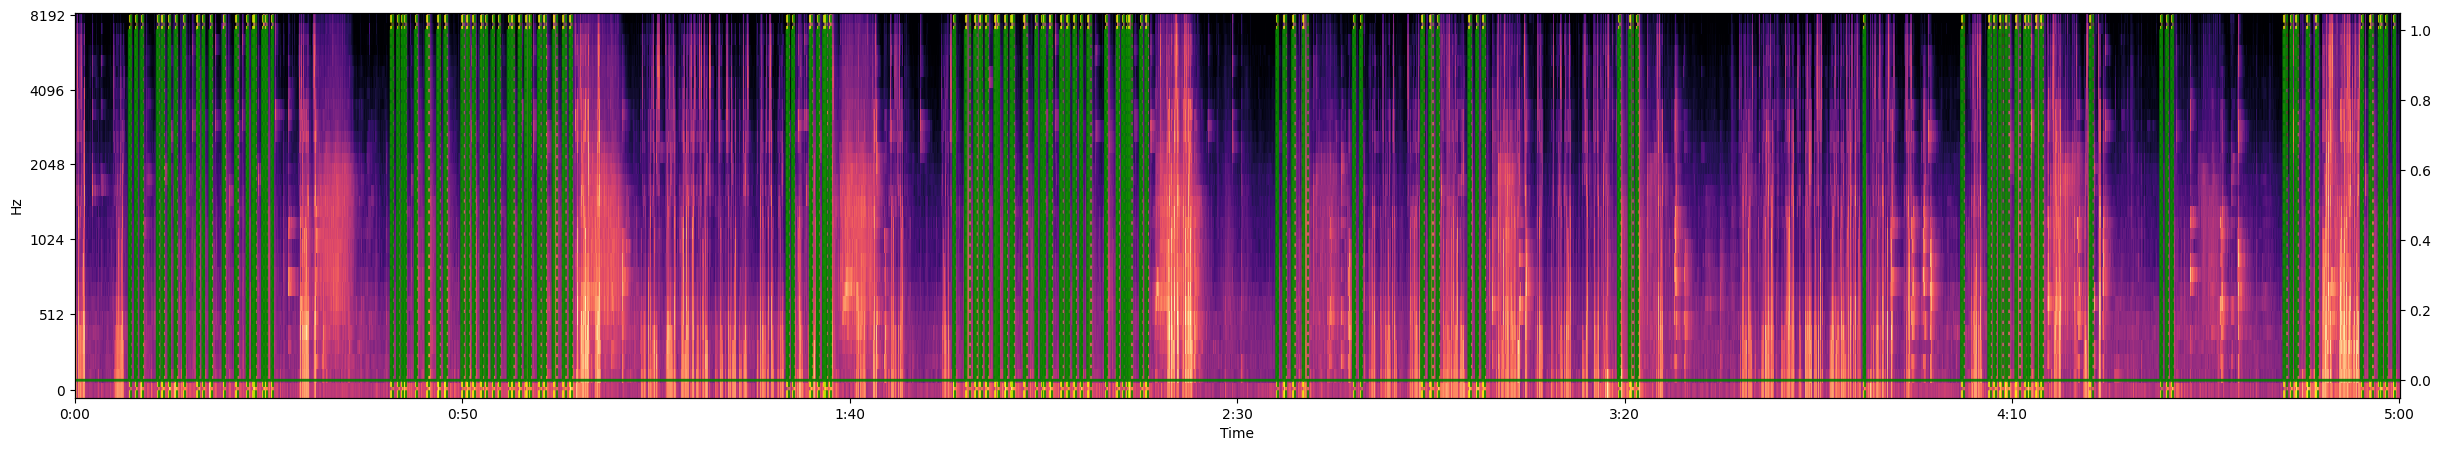

In [12]:

def plot_spectrogram(ax, spec, events=None, label_activations=None, predictions=None):
    events_lw = 1.5
    
    # Plot spectrogram
    librosa.display.specshow(ax=ax, data=spec, hop_length=hop_length, x_axis='time', y_axis='mel', sr=samplerate)

    # Plot events
    if events is not None:
        for start, end in zip(events.start, events.end):
            ax.axvspan(start, end, alpha=0.2, color='yellow')
            ax.axvline(start, alpha=0.7, color='yellow', ls='--', lw=events_lw)
            ax.axvline(end, alpha=0.8, color='green', ls='--', lw=events_lw)

    label_ax = ax.twinx()
    
    # Plot event activations
    if label_activations is not None:
        a = label_activations.reset_index()
        a['time'] = a['time'].dt.total_seconds()
        label_ax.step(a['time'], a['event'], color='green', alpha=0.9, lw=2.0)

    # Plot model predictions
    if predictions is not None:
        p = predictions.reset_index()
        p['time'] = p['time'].dt.total_seconds()
        label_ax.step(p['time'], p['probability'], color='blue', alpha=0.9, lw=3.0)
            
        label_ax.axhline(0.5, ls='--', color='black', alpha=0.5, lw=2.0)
            
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
#ax.set_xlim(15, 25)

(0.0, 15.0)

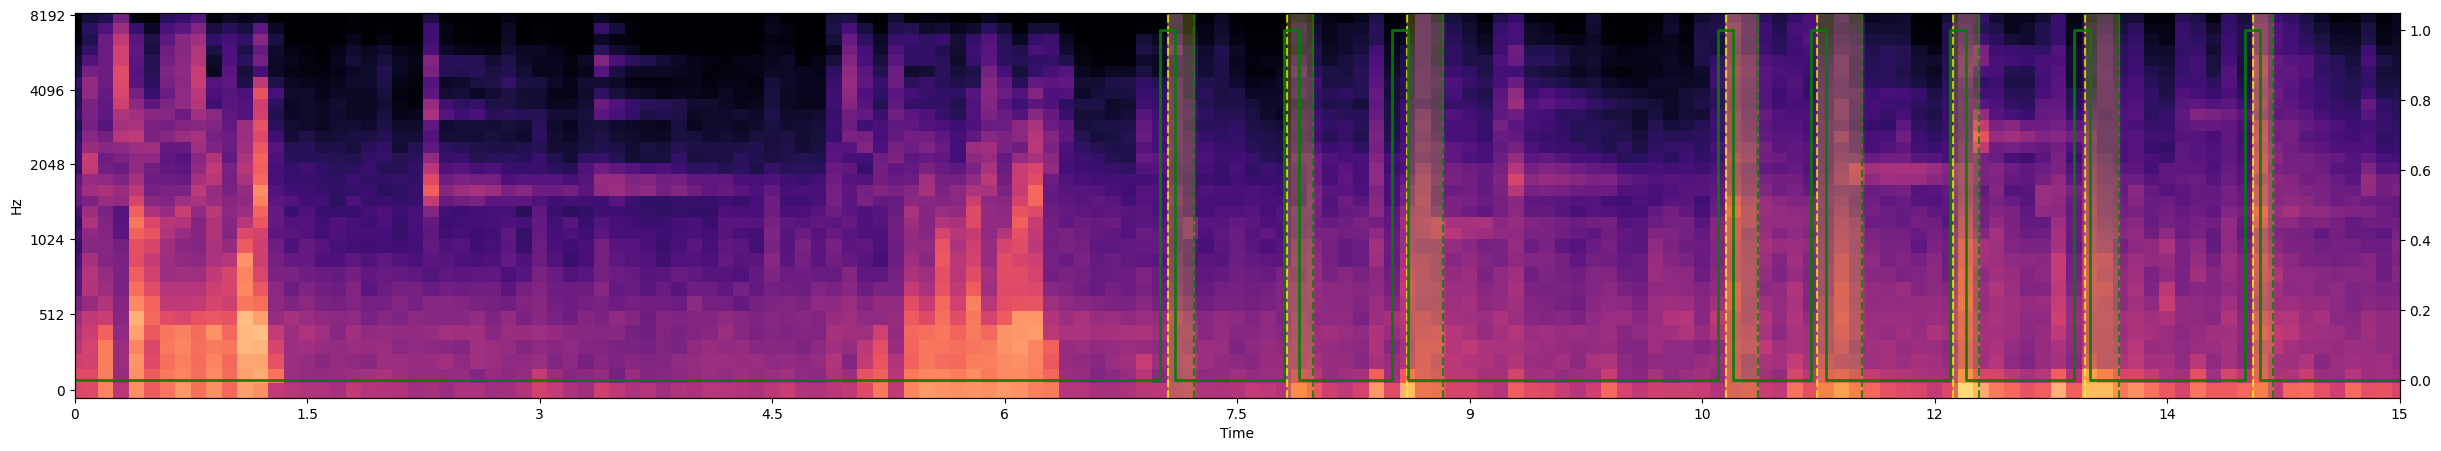

In [13]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(0, 15)
#ax.set_xlim(110, 120)

(15.0, 30.0)

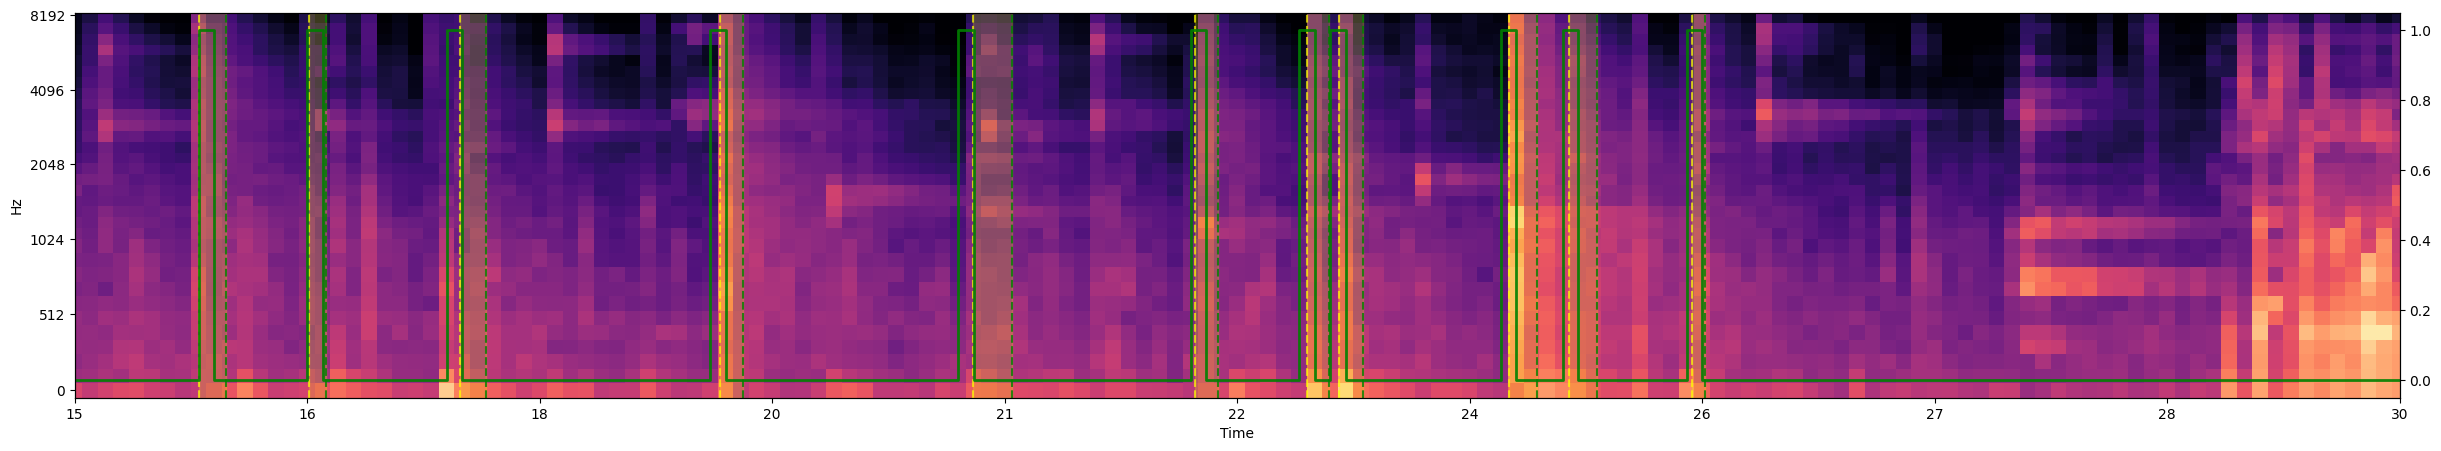

In [14]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(15, 30)


## Chop audio input into fixed-length windows

Our model will take as input short windows of fixeed length.

The windows are extracted with overlap.

This ensures that

1) All events has always has some windows where it appears in the middle of a window (and not split between two windows)
2) We get more instance to train on, by having windows that are shifted versions of eachother. Effectively the same as time-shift data augmentation


In [15]:
# duration is set to be a bit bigger than our event sizes
window_duration = 0.801 
window_length = int(window_duration / time_resolution)
window_length

8

In [16]:


windows = pandas.DataFrame({
    'spectrogram': compute_windows(spec, frames=window_length, step=2),
    'labels': compute_windows(l.values.T, frames=window_length, step=2),
    'file': audio_path,
})
windows['event'] = windows.labels.apply(lambda labels: numpy.any(labels, axis=-1)).astype(int)
windows[windows.event == True].head(5)

,spectrogram,labels,file,event
start_index,,,,
64,"[[80.34738159179688, 80.4749755859375, 77.8066...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]",data/source2.wav,1
66,"[[77.80665588378906, 77.75106811523438, 78.663...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]",data/source2.wav,1
68,"[[78.66357421875, 80.93084716796875, 81.303291...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]",data/source2.wav,1
70,"[[81.30329132080078, 78.76071166992188, 80.862...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",data/source2.wav,1
72,"[[80.86276245117188, 79.48822784423828, 79.003...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]",data/source2.wav,1


## Visualize the windows

Again ensuring that events are clearly seen, and that labels and events are correctly aligned.


""


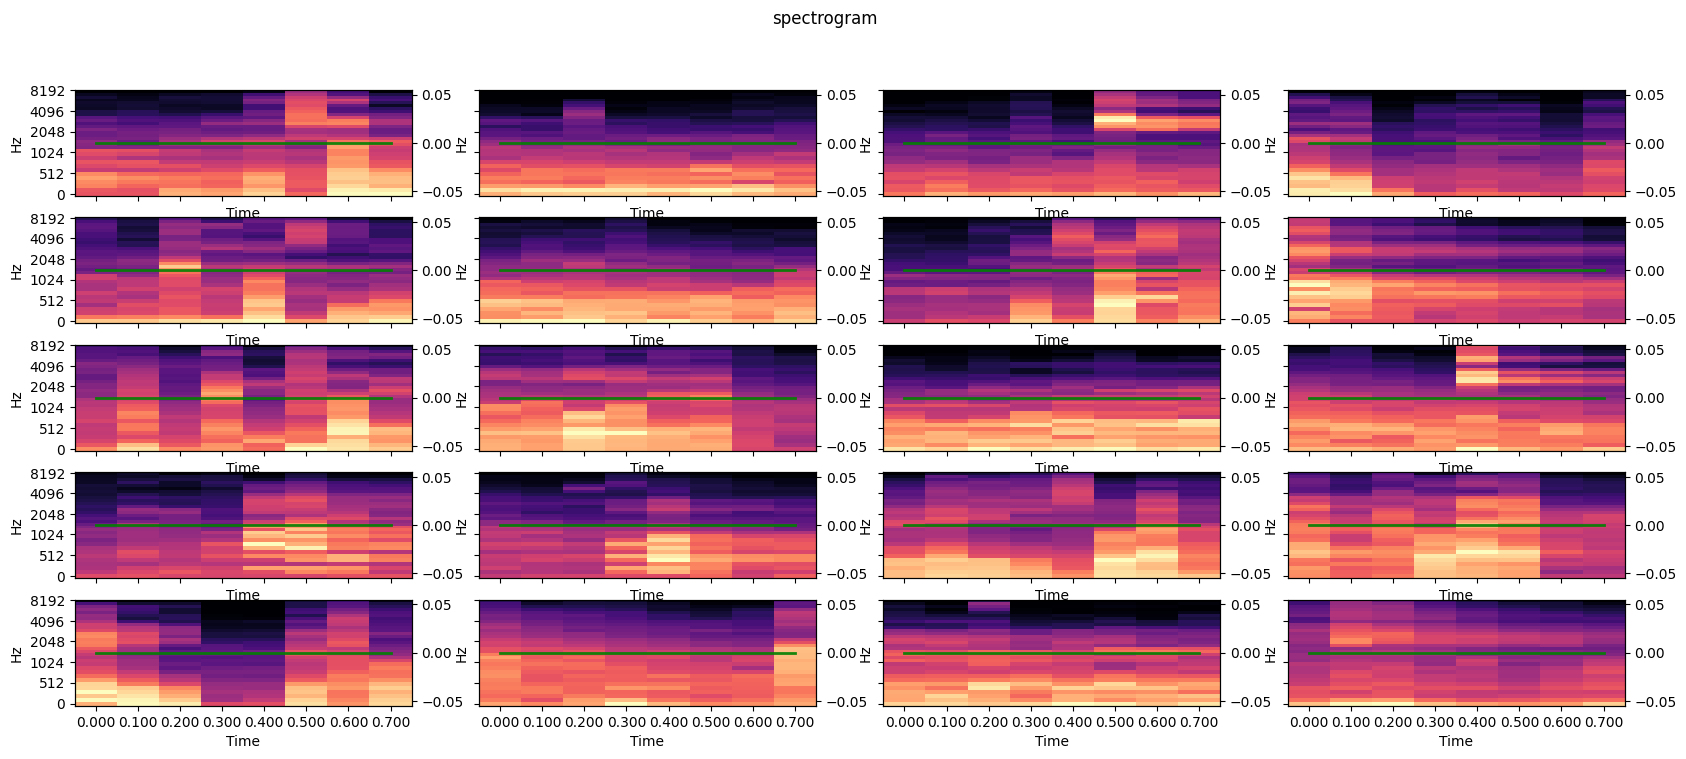

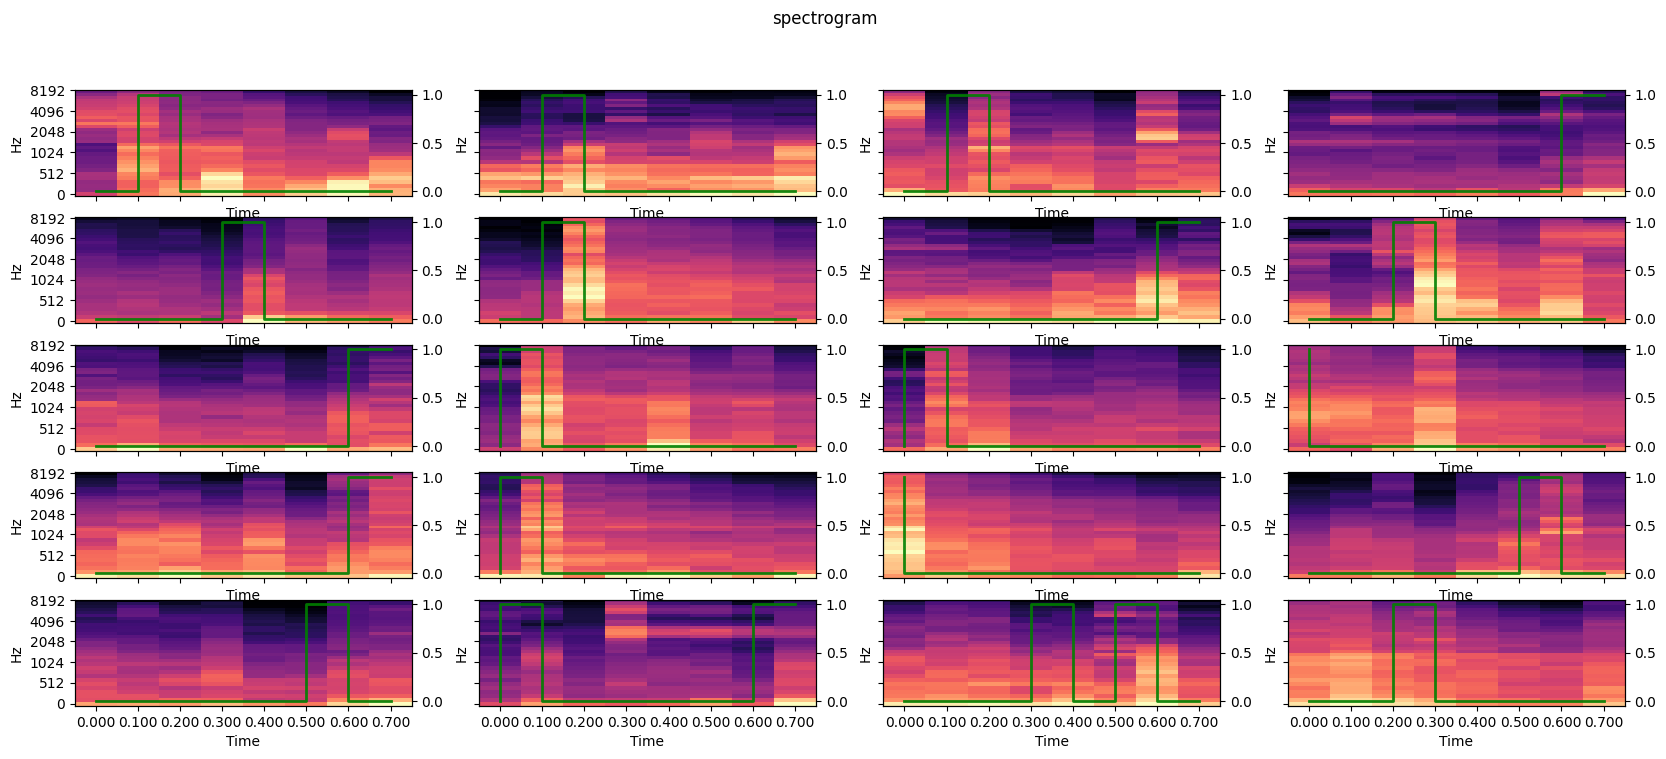

In [17]:
def plot_windows(wins, col_wrap=None, height=4, aspect=1):
    specs = wins.spectrogram
    
    nrow = 1
    ncol = len(specs)
    if col_wrap is not None:
        nrow = int(numpy.ceil(ncol / col_wrap))
        ncol = col_wrap

    fig_height = height * nrow
    fig_width = height * aspect * ncol
    fig, axs = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(fig_width, fig_height))
    axs = numpy.array(axs).flatten()
    
    fig.suptitle(specs.name)
    for ax, s, l in zip(axs, specs, wins.labels):
    
        l = numpy.squeeze(l)
        ll = pandas.DataFrame({
            'event': l,
            'time': pandas.to_timedelta(numpy.arange(l.shape[0])*hop_length/samplerate, unit='s'),
        })

        plot_spectrogram(ax, s, label_activations=ll)

windows.groupby('event').sample(n=20).groupby('event').apply(plot_windows, col_wrap=5, aspect=2, height=2)

## Dataset splitting



In [18]:
# split windows into train, val, test
# When having recordings from multiple matches, would be much better to split by match!


dataset = dataset_split_sequentially(windows, val_size=val_size, test_size=test_size)
dataset.split.value_counts()

/home/jon/projects/machinehearing/handson/badminton/sed_utils.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[train_idx, column] = 'train'


split
train    1050
val       225
test      225
Name: count, dtype: int64

In [19]:
val_start = dataset[dataset.split == 'val'].reset_index()['start_index'].min() * time_resolution
test_start = dataset[dataset.split == 'test'].reset_index()['start_index'].min() * time_resolution
test_end = dataset[dataset.split == 'test'].reset_index()['start_index'].min() * time_resolution
train_start = 0
train_start, val_start, test_start, test_end

(0, 210.0, 255.0, 255.0)

## Build model

Using a simple CRNN designed for Sound Event Detection (SED),
that has shown to do well in several tasks.

It outputs a time-series vector representing event activation,
with time-resolution the same as the input spectrogram time-resolution.

Reference:

    Sharath Adavanne, Pasi Pertila and Tuomas Virtanen
    "Sound event detection using spatial features and convolutional recurrent neural network"
    IEEE International Conference on Acoustics, Speech and Signal Processing
    (ICASSP 2017)
    
https://github.com/sharathadavanne/sed-crnn

In [37]:
import tensorflow.keras

def build_model(input_shape, dropout=0.5, lr=0.01, class_weights=None, name='sedgru'):

    from sed_utils import build_sedgru, build_sednet
    
    # Model
    if name == 'sednet':
        model = build_sednet(input_shape, n_classes=1,
                         filters=10,
                         cnn_pooling=[2, 2, 2],
                         rnn_units=[5, 5],
                         dense_units=[16],
                         dropout=dropout,
                        )
    elif name == 'sedgru':
        model = build_sedgru(input_shape, n_classes=1,
                             reduction_units=(8,),
                             rnn_units=[5, 5],
                             dense_units=[16],
                             dropout=dropout)
    else:
        raise ValueError('')
        
    # Metrics
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    # Loss
    if class_weights is None:
        loss = tensorflow.keras.losses.BinaryCrossentropy()
    else:
        loss = weighted_binary_crossentropy(*class_weights)
       
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(window_length, 32))
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 8, 32)]           0         
                                                                 
 time_distributed_20 (TimeD  (None, 8, 8)              264       
 istributed)                                                     
                                                                 
 bidirectional_14 (Bidirect  (None, 8, 5)              450       
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 8, 5)              360       
 ional)                                                          
                                                                 
 time_distributed_21 (TimeD  (None, 8, 16)             96        
 istributed)                                               

## Model training



In [66]:

epochs = 400
batch_size = 8*64

from tqdm.keras import TqdmCallback

# Compute the spectral background across entire clip
# Used for spectral subtraction, a type of preprocessing/normalization technique that is often useful
Xm = numpy.expand_dims(numpy.mean(numpy.concatenate([s.T for s in dataset.spectrogram]), axis=0), -1)

def get_XY(split):
    # convenience to convert
    d = dataset[dataset.split == split]
    
    X = numpy.expand_dims(numpy.stack([(s-Xm).T for s in d.spectrogram]), -1)

    Y = numpy.stack([ l.T for l in d.labels], axis=0)    
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

from sed_utils import compute_class_weights

class_weights = compute_class_weights(train[1])
#class_weights = None # disable class weights
print('Class weights', class_weights)

# make sure to stop when model does not improve anymore / starts overfitting
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
progress_bar = TqdmCallback()

import tensorflow.math
def schedule(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tensorflow.math.exp(-0.1)

lr_callback = tensorflow.keras.callbacks.LearningRateScheduler(schedule)

#lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.01)

model = build_model(input_shape=(window_length, 32), dropout=0.33, lr=2*0.001, class_weights=class_weights)
hist = model.fit(x=train[0], y=train[1],
        validation_data=val,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            progress_bar,
            #lr_callback,
            #early_stop,
        ],
        verbose=False, # using progress bar callback instead
)



Class weights [0.73735955 1.55325444]




0epoch [00:00, ?epoch/s]


0batch [00:00, ?batch/s]

  0%|                                                                                                                                                                                                             | 0/400 [00:00<?, ?epoch/s]


  0%|                                                                                                                                                                                                         | 0.00/3.00 [00:00<?, ?batch/s]


 33%|█████████████████████████████████████████████                                                                                          | 1.00/3.00 [00:06<00:12, 6.11s/batch, loss=0.531, pr_auc=0.0382, precision=0.0412, recall=0.458]

  0%|▏                                                                       | 1/400 [00:06<45:14,  6.80s/epoch, loss=0.531, pr_auc=0.0421, precision=0.0417, recall=0.338, val_loss=0.508, val_pr_auc=0.0193, val_precision=0, va

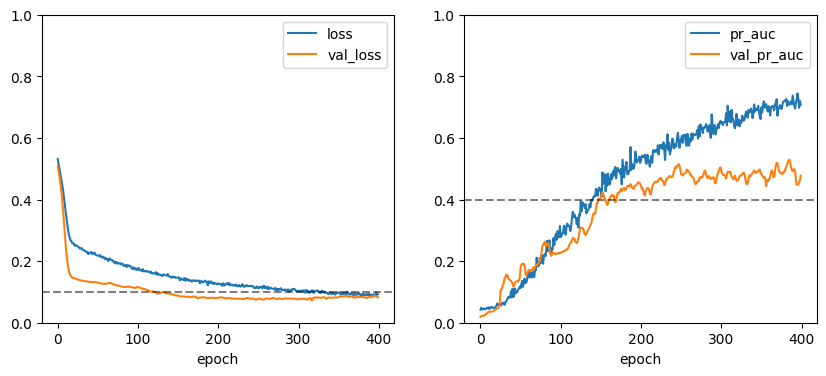

In [67]:
def plot_history(history):
    from matplotlib import pyplot as plt
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    history = pandas.DataFrame(hist.history)
    history.index.name = 'epoch'
    history.plot(ax=axs[0], y=['loss', 'val_loss'])
    history.plot(ax=axs[1], y=['pr_auc', 'val_pr_auc'])
    axs[1].set_ylim(0, 1.0)
    axs[1].axhline(0.40, ls='--', color='black', alpha=0.5)
    
    axs[0].axhline(0.10, ls='--', color='black', alpha=0.5)
    axs[0].set_ylim(0, 1.0)




plot_history(hist)


## Evaluate model using frame-based metrics

Note that the per-frame task is quite tricky - it requires the event predictions to fit exactly the labels
within the specified time-resolution (usually between 10 to 100 milliseconds).

This not only requires the model to be incredibly precise, but also that the labels are very precise.
It is easier (and more important) to achieve a good performance on a per-event or per-window basis.

In [68]:
test = get_XY(split='test')

results = pandas.DataFrame({
    'split': [ 'test', 'train', 'val' ],
})
def get_metric(split):
    X, Y = get_XY(split=split)
    r = model.evaluate(x=X, y=Y, return_dict=True, verbose=False)
    return pandas.Series(r)

e = results.split.apply(get_metric)
results = pandas.merge(results, e, right_index=True, left_index=True).set_index('split')
results


,loss,pr_auc,precision,recall
split,,,,
test,0.110753,0.506218,0.566667,0.566667
train,0.069924,0.818617,0.821958,0.736702
val,0.082620,0.477104,0.461538,0.545455


#### Check how predictions are distributed

Should be bi-modal with most values near 0.0 or 1.0 (for event).

Useful for diagnosing issues, for example with class balance, which can lead to values not spreading across the entire range.

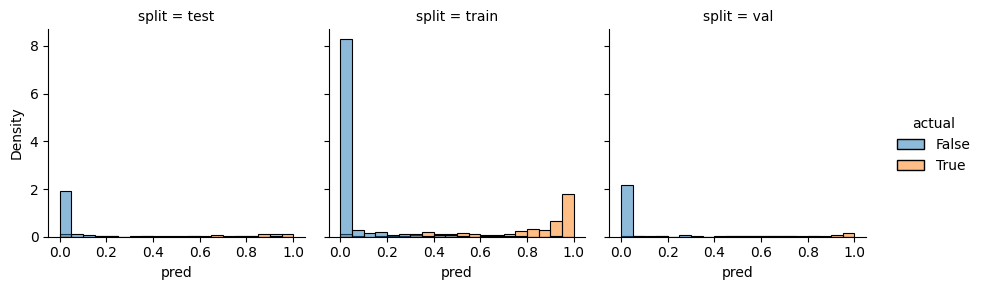

In [69]:
%matplotlib inline

import seaborn

rr = []
for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = numpy.squeeze(Y)
    y_pred = numpy.squeeze(model.predict(X, verbose=False))

    #print(y_pred.shape)
    #print(y_true.shape)
    
    r = pandas.DataFrame({
        'pred': numpy.max(y_pred, axis=1),
        'actual': numpy.any(y_true, axis=1),
        'split': split,
    })
    rr.append(r)

r = pandas.concat(rr, ignore_index=True)
seaborn.displot(kind='hist', data=r, x='pred', hue='actual', col='split', height=3, aspect=1, binrange=(0.0, 1.0), stat='density', binwidth=0.05)
    

#### Frame-wise precision/recall trade-off 

(225,) (225,)
(1050,) (1050,)
(225,) (225,)


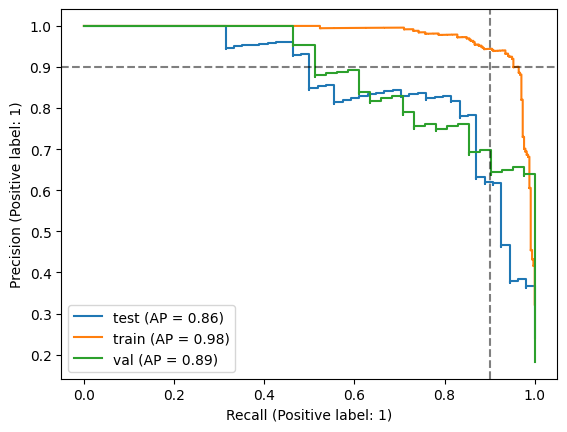

In [72]:

from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1)

for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = Y
    y_pred = model.predict(X, verbose=False)
    
    y_true = numpy.any(y_true, axis=1)[:,0]
    y_pred = numpy.max(y_pred, axis=1)[:,0]
    print(y_true.shape, y_pred.shape)
    
    PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y_true, y_pred=y_pred, name=split)

ax.axhline(0.9, ls='--', color='black', alpha=0.5)
ax.axvline(0.9, ls='--', color='black', alpha=0.5)

## Run on entire audio clip

(210.0, 255.0)

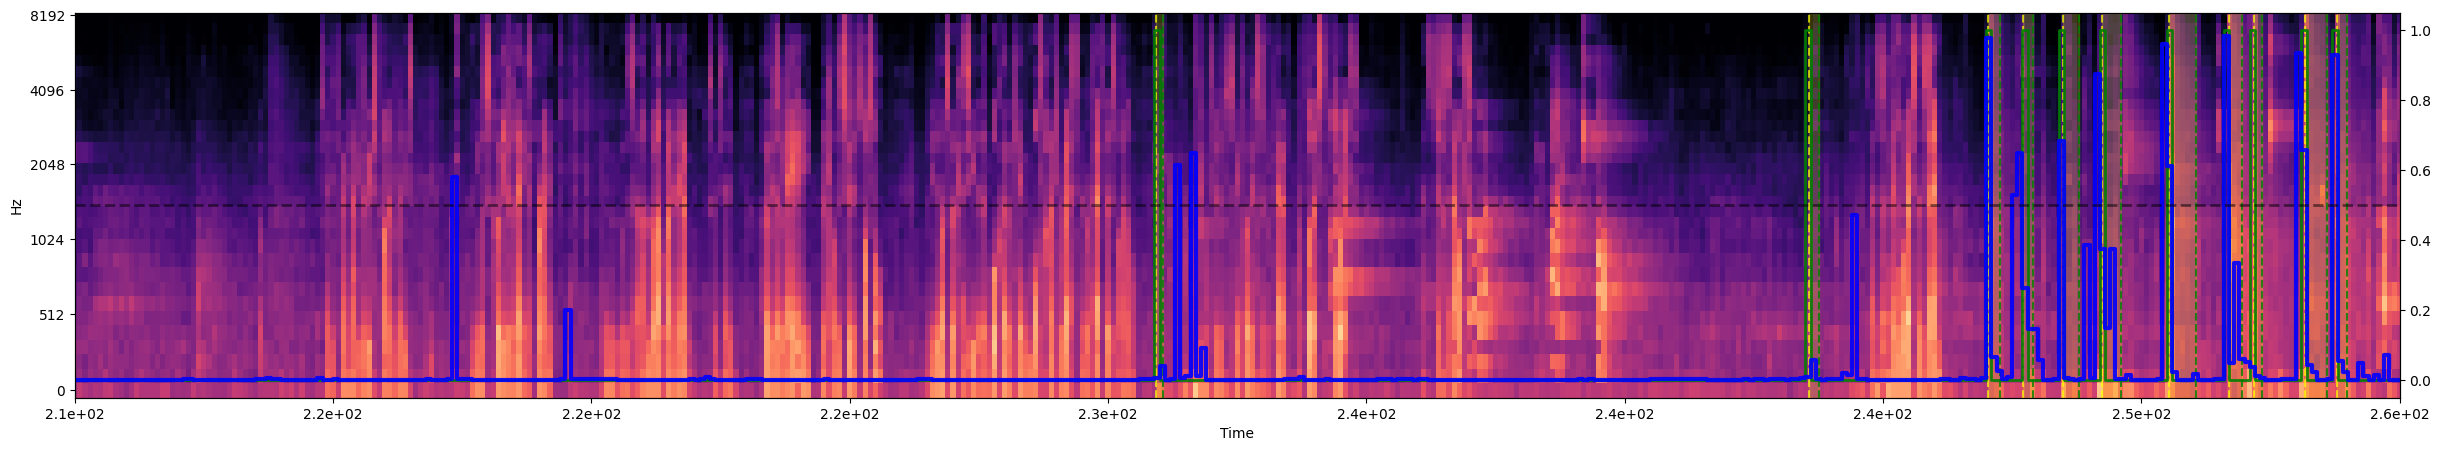

In [78]:


def predict_spectrogram(model, spec):
    
    # prepare input data. NOTE: must match the training preparation in getXY
    window_hop = 1
    wins = compute_windows(spec, frames=window_length, step=window_hop)       
    X = numpy.expand_dims(numpy.stack( [ (w-Xm).T for w in wins ]), -1)
    
    # make predictions on windows
    y = numpy.squeeze(model.predict(X, verbose=False))
    
    out = merge_overlapped_predictions(y, window_hop=window_hop, time_resolution=time_resolution)

    return out
    
predictions = predict_spectrogram(model, spec)
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)



ax.set_xlim(val_start, test_start)



(255.0, 300.0)

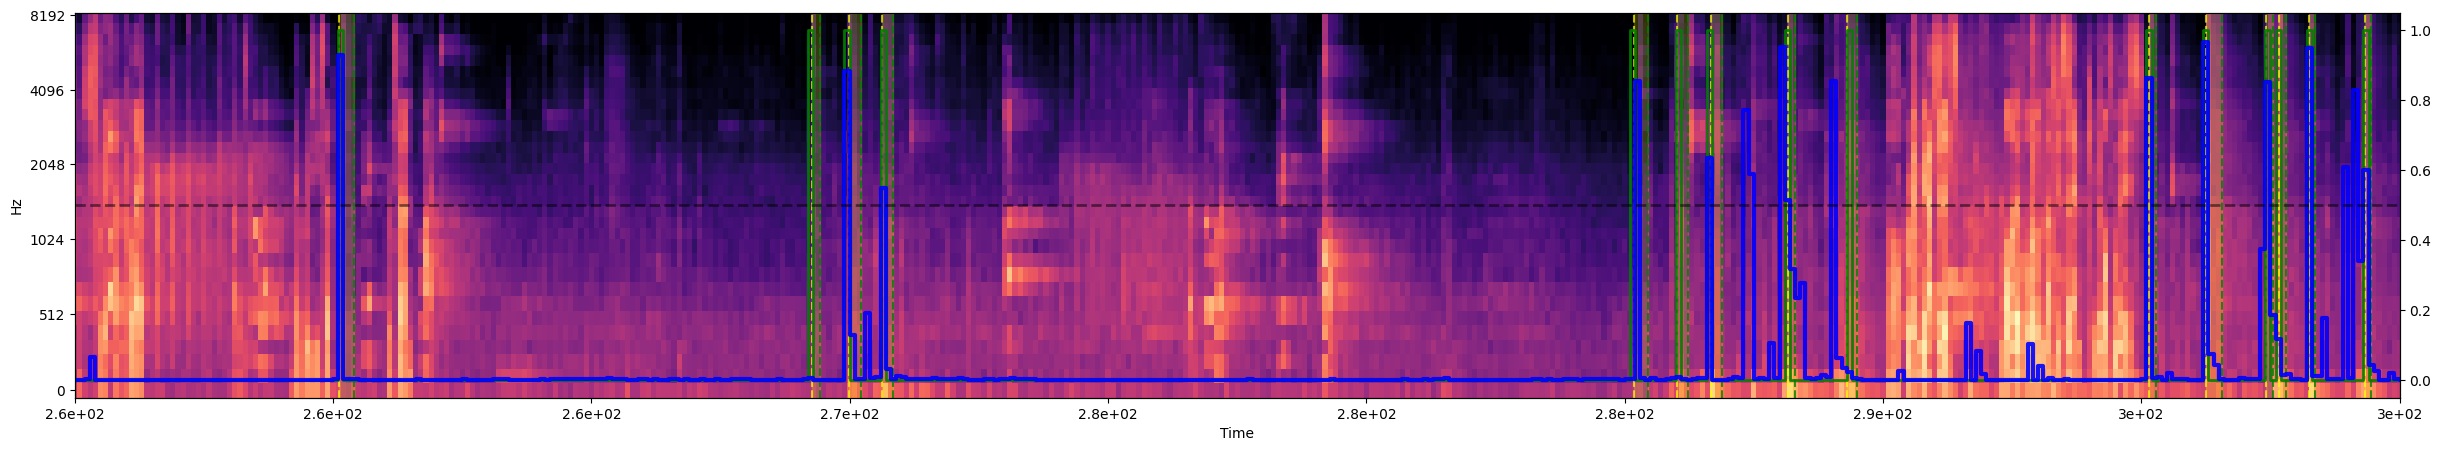

In [79]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)

ax.set_xlim(test_start, 300)

In [73]:
#seaborn.displot(kind='hist', data=predictions, x='probability', binrange=(0.1, 1.0), binwidth=0.05, height=3)
#seaborn.displot(kind='hist', data=predictions, x='probability', binrange=(0.00, 0.099), binwidth=0.05, height=3)

### Evaluate event-detection performance

Using sed_eval https://tut-arg.github.io/sed_eval/sound_event.html
 

In [80]:
annotations.shape

(120, 5)

In [81]:

            
events_from_predictions(predictions)

,start,end,label
0,0 days 00:00:07.100000,0 days 00:00:07.200000,yes
1,0 days 00:00:07.900000,0 days 00:00:08,yes
2,0 days 00:00:08.600000,0 days 00:00:08.700000,yes
3,0 days 00:00:10.700000,0 days 00:00:10.800000,yes
4,0 days 00:00:11.100000,0 days 00:00:11.200000,yes
...,...,...,...
109,0 days 00:04:57.500000,0 days 00:04:57.600000,yes
110,0 days 00:04:58.300000,0 days 00:04:58.400000,yes
111,0 days 00:04:59,0 days 00:04:59.100000,yes
112,0 days 00:04:59.200000,0 days 00:04:59.300000,yes


In [82]:
annotations

,start,end,event,duration,file
0,7.055938,7.220668,yes,0.164730,source2.wav
1,7.824678,7.989408,yes,0.164730,source2.wav
2,8.593418,8.826786,yes,0.233368,source2.wav
3,10.652544,10.858457,yes,0.205913,source2.wav
4,11.242827,11.531104,yes,0.288277,source2.wav
...,...,...,...,...,...
120,296.253290,296.569023,yes,0.315733,source2.wav
121,297.406401,297.543676,yes,0.137275,source2.wav
122,297.667223,297.790771,yes,0.123548,source2.wav
123,298.243778,298.367326,yes,0.123548,source2.wav


In [84]:
   
                        
p = predictions.copy()
a = annotations
a = a[a.start > val_start] # avoid including training data
p = p.loc[pandas.Timedelta(val_start, unit='s'):]
p['file'] = a['file'].iloc[0]
pr = compute_pr_curve(a, p, tolerance=0.2, thresholds=50)
pr.head(1)

,threshold,f_measure,precision,recall,error_rate,substitution_rate,deletion_rate,insertion_rate
0,0.0,0.237624,0.16,0.461538,2.961538,0.0,0.538462,2.423077


<Axes: xlabel='threshold', ylabel='f_measure'>

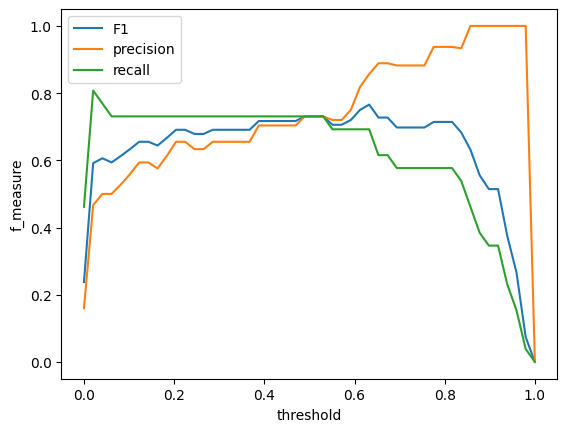

In [85]:
pr = pr.fillna(0.0)
fig, ax = plt.subplots(1)
seaborn.lineplot(ax=ax, data=pr, x='threshold', y='f_measure', label='F1')
seaborn.lineplot(ax=ax, data=pr, x='threshold', y='precision', label='precision')
seaborn.lineplot(ax=ax, data=pr, x='threshold', y='recall', label='recall')


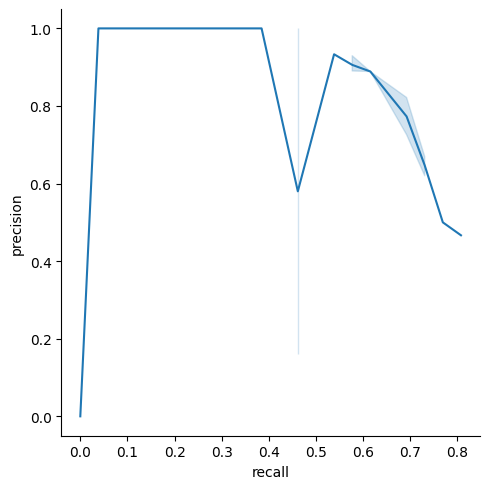

In [86]:
seaborn.relplot(kind='line', data=pr.sort_values('recall'), x='recall', y='precision')


(0.0, 1.01)

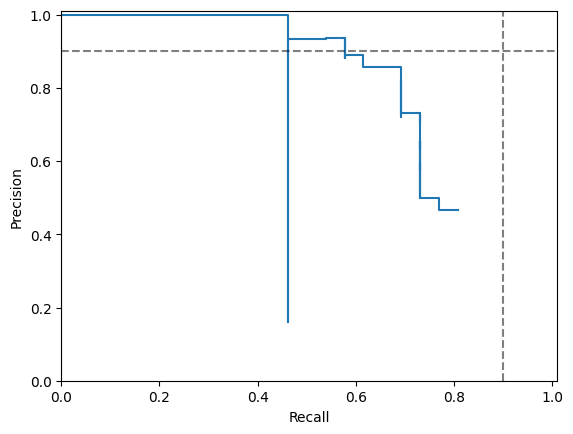

In [87]:
%matplotlib inline
pp = pr.dropna().sort_values('recall', ascending=False)
d = PrecisionRecallDisplay(precision=pp.precision, recall=pp.recall)
d.plot()
ax = d.ax_
ax.axvline(0.9, ls='--', color='black', alpha=0.5)
ax.axhline(0.9, ls='--', color='black', alpha=0.5)
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)

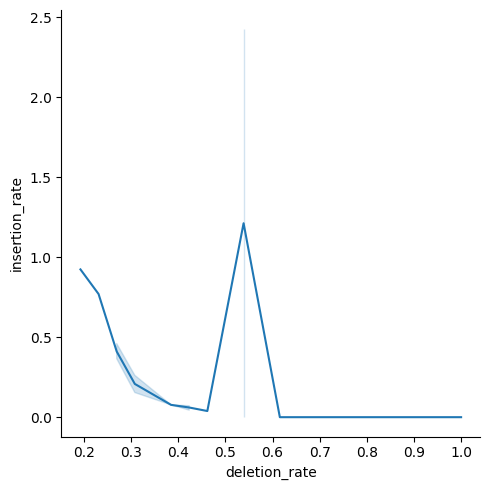

In [88]:
seaborn.relplot(kind='line', data=pr.sort_values('deletion_rate'), x='deletion_rate', y='insertion_rate')

